![](https://drive.google.com/uc?export=view&id=1-5X9OUkA-C2Ih1gOS9Jd7GmkTWUEpDg1)

Asignatura: Introducción a Data Science

Profesor: Juan Bekios Calfa

---


# Laboratorio Número 5.3: Aprendizaje no supervisado (Parte 03)


**Objetivo:** 


* Utilizar el algoritmo k-Mean para comprimir una imagen.
* Calcular el k óptimo donde el error se hace menor.
* Utilizar el dataset LFW para construir un sistema de identificación de caras utilizando PCA y SVM.





# 1. Comprimir una imagen utilizando aprendizaje no supervisado k-Means

En este laboratorio analizaremos como comprimir una imagen utilizando el algoritmo de aprendizaje no supervisado K-means. Esta es una técnica de compresión de imágenes con pérdida.

## 1.1 k-Means

La agrupación en clústeres es el proceso de agrupar puntos de datos que son comparables entre sí en agrupaciones distintas. Por ejemplo, si tenemos un conjunto de datos que contiene las ubicaciones de personas de todo el mundo, podemos dividirlo en grupos distintos según los estados, y cada grupo incluye solo personas de ese estado.

K-Means es una técnica de aprendizaje automático que divide los puntos de datos en grupos separados específicos, y cada punto de datos pertenece a solo uno de estos grupos.

Si observamos las estadísticas detrás de esto, podemos ver que K-Means Clustering, como su nombre lo indica, toma en consideración la media aritmética del punto de datos y forma grupos que contienen datos homogéneos, es decir, puntos de datos con medios comparables en uno. (Revisar el material de clases)

## 1.2 Cargamos una imagen

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/COQ-ESC-UCN/Classes/IntroDataScience/IDS-2022-2/Laboratorio/Laboratorio05: Clasificacion

## 1.3 Importamos las librerías requeridas



In [ ]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## 1.4 Desplegamos la imagen en pantalla.

In [ ]:
plt.rcParams['figure.figsize'] = (20, 12)
image = io.imread('imagen-prueba.jpeg')
labels = plt.axes(xticks=[], yticks=[])
labels.imshow(image);

## 1.5 Convertimos la imagen en un vector de tres canales

In [ ]:
rows = image.shape[0]
cols = image.shape[1]

image_flat = image.reshape(rows*cols, 3)

print(image_flat)

## 1.6 Inicializamos k-Mean con todos los pixeles de la imagen

In [ ]:
kmeans = KMeans(n_clusters=32)
kmeans.fit(image_flat)

## 1.7 Reemplazamos cada pixel por los centroides obtenidos en el cluster

In [ ]:
print(kmeans.labels_)
print(kmeans.cluster_centers_[kmeans.labels_])

In [ ]:
compressed_image = kmeans.cluster_centers_[kmeans.labels_]
compressed_image = np.clip(compressed_image.astype('uint8'), 0, 255)

image_compress = compressed_image.reshape(rows, cols, 3)
print(image_compress.shape)

1.8 Guardamos la imagen y desplegamos la imagen de salida

In [ ]:
io.imsave('compressed_image_64.png', image_compress)
io.imshow(image_compress)
io.show()

# 2. PCA (Principal Component Analysis)

[Ejemplo utilizado (sklearn)](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py)


In [ ]:
from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

## 2.1 Cargamos el dataset desde la red

El dataset utilizado para este experimento se llama “Labeled Faces in the Wild” ([LFW](http://vis-www.cs.umass.edu/lfw/)).

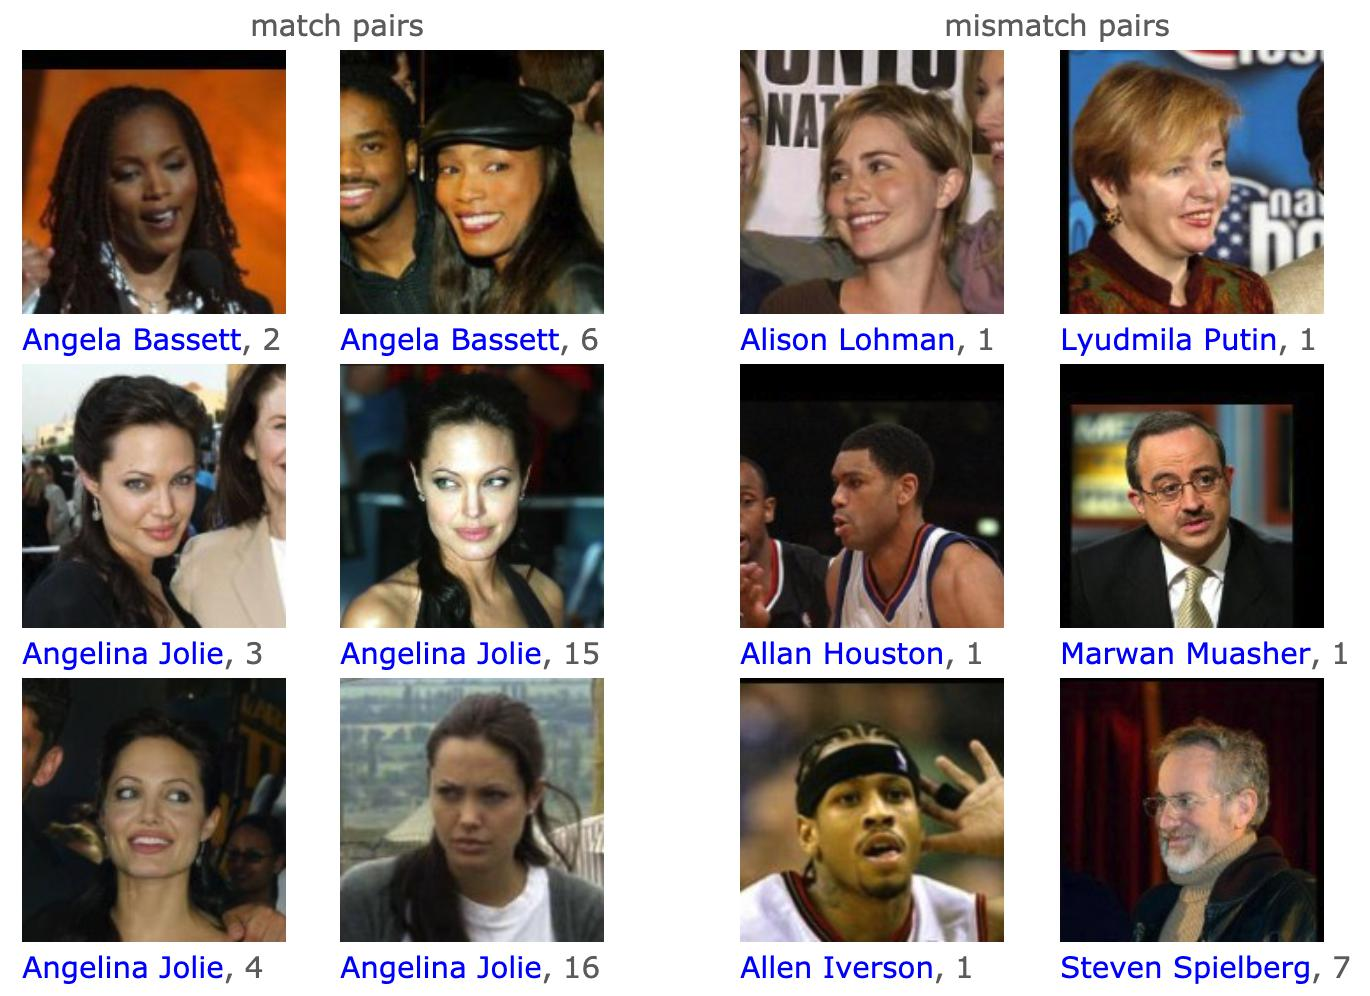

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# obtener las dimensiones de la imagen
n_samples, h, w = lfw_people.images.shape

# para el aprendizaje automático utilizamos los 2 datos directamente 
#(ya que la información de las posiciones relativas de los píxeles
# es ignorada por este modelo)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Tamaño del dataset:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

## 2.2 Dividimos los datos en conjunto de entrenamiento y pruebas

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 2.3 Calculamos los componentes principales (autovalores) de dataset de caras.

PCA es un algoritmo no supervisado para extracción de características y reducción de dimensionalidad.

In [ ]:
n_components = 150

print(f"Extraemos los {n_components} eigenfaces (autovectores) de {X_train.shape[0]} caras")

t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print(f"Terminado {time() - t0:0.3f}s")

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Proyectamos los datos utilizando la base ortonormal")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(f"Terminado en {time() - t0:0.3f}s")

## 2.4 Entrenamos el modelo de clasificación SVM

In [ ]:
print("Ajustando el clasificador a el conjunto de entrenamiento")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10)

clf = clf.fit(X_train_pca, y_train)
print(f"Terminado {time() - t0:0.3f}s")
print("El mejor estimador encontrado utilizando búsqueda de grilla es:")
print(clf.best_estimator_)

## 2.5 Evaluación cuantitativa de la calidad del modelo

In [ ]:
print("Predicción del nombre de la persona utilizando el conjunto de pruebas")
t0 = time()
y_pred = clf.predict(X_test_pca)
print(f"Terminado {time() - t0:0.3f}s")

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical")

## 2.6 Evaluación cuantitativa de las predicciones utilizando matplotlib

In [ ]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [ ]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return f"Predicción: {pred_name}\nReal:     {true_name}"

Dibujamos cada una de sus caras y su predicción

In [ ]:
prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)

## 2.7 Visualización de los autovectores más significativos (eigenfaces).

In [ ]:
eigenface_titles = [f"eigenface {i}" for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()